# Lab 4 : introduction to MDO through the Sellar Problem

This notebook is written as an introduction to MDO formulations with Python. 

## Design problem 


In this notebook, we consider The 'Sellar Problem' to illustrate the handling of multidiscipinary couplings and MDO formulations

We consider a 2-discipline MDO problem with two shared design variables, one local design variable and two coupling variables.  

The formulation of the global design problem is as follows:

$min \; \;z_1^2+z_{sh_2}+y_1+e^{(-y_2)}$

$w.r.t. \{z_{sh_1}, z_{sh_2}, z_{1}\}$
 
$s.t. \frac{y_1}{3.16}-1\geq 0$

$\; \; \; \;\;1-\frac{y_2}{24}\geq 0$

$\; \; \; \;\;-10\leq z_{sh_1}\leq 10$
 
$\; \; \; \;\;0\leq z_{sh_2}\leq 10$
 
$\; \; \; \;\;0\leq z_{1}\leq 10$

Equations of the disciplines: 

$c_1(z_{sh_1}, z_{sh_2}, z_{1}, y_{2}) = z_{sh_1}^2+z_{1}+ z_{sh_2}  - 0.2 y_{2}$

$c_2(z_{sh_1}, z_{sh_2}, y_{1}) =  z_{sh_1}+ z_{sh_2} + \sqrt{y_1}$

##  Reference
Sellar, R. S., Batill, S. M., and Renaud, J. E., “Response Surface Based, Concurrent Subspace Optimization for Multidisciplinary System Design,” Proceedings References 79 of the 34th AIAA Aerospace Sciences Meeting and Exhibit, Reno, NV, January 1996

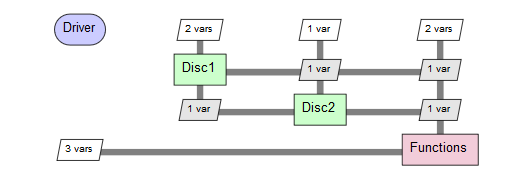

In [1]:
from IPython.display import Image
Image('Sellar.png',width = 750)

## Exercice
- Identify N2 Chart
- Code the different disciplines, objective and constraints in  python functions
- Implement an MDA (using Gauss Seidel Scheme) and test for ($z_{sh_1}=5.$, $z_{sh_2}=2.$, $z_{1}= 2.$), return  converged values of $y_{1}$ and $y_{2}$)
- Implement functions for computing the objective function and constraints
- Implement a MDF formulation and solve it using SLSQP algorithm of `Scipy` (see Lab 1)
- Implement an IDF formulation and solve it using SLSQP algorithm of `Scipy` package (see Lab 1)


https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_slsqp.html

In [3]:
from scipy.optimize import fmin_slsqp
import numpy as np

### Step 1: code the different disciplines, objective and constraint functions

In [53]:
def D1(z_sh1, z_sh2, z1, y2):
    return z_sh1*z_sh1 + z1 + z_sh2 - 0.2 *y2

def D2(z_sh1, z_sh2, y1):
    return z_sh1 + z_sh2 + np.sqrt(y1)

def objective_function(z, y1, y2):
    z_sh1=z[0]
    z_sh2=z[1]
    z1=z[2]
    return z1*z1 + z_sh2 + y1 + np.exp(-y2)

def constraints(y1,y2):
    return [y1/3.16 - 1, 1-y2/24.0]



### Step 2: code the MDA using Gauss Seidel Scheme

In [54]:
def MDA(z_sh1, z_sh2, z1, y2_guess):
    k = 0
    # TODO : make it params
    tol = 0.01
    kmax = 50
    # first guess
    y1 = D1(z_sh1, z_sh2, z1, y2_guess)
    y2 = D2(z_sh1, z_sh2, y1)
    
    delta = abs(y2-y2_guess)
    
    k+=1
    
    while(delta > tol and k < kmax):
        y2_guess = y2
        y1 = D1(z_sh1, z_sh2, z1, y2_guess)
        y2 = D2(z_sh1, z_sh2, y1)
        delta = abs(y2-y2_guess)
        k+=1
    
    if(k<kmax):
        return y1, y2, k
    else:
        return "not converged"


### Step 3: verify the MDA on ($z_{sh_1}=5.$, $z_{sh_2}=2.$, $z_{1}= 2.$)

In [55]:
z_sh1 = 5.0
z_sh2 = 2.0
z1 = 2.0
y1_guess = 1.0
print(MDA(z_sh1, z_sh2, z1, y1_guess))

(26.569918695038105, 12.154601700911343, 3)


### Step 4: Code the MDF for objective and constraint that aggregates the computation of the MDA and the objective and constraints functions
$\rightarrow$ clue: code 2 separate functions :
- MDF_obj : $\mathbb{R}^3 \rightarrow \mathbb{R}$
- MDF_const : $\mathbb{R}^3 \rightarrow \mathbb{R}^2$

In [75]:
def MDF_obj(z):
    z_sh1=z[0]
    z_sh2=z[1]
    z1=z[2]
    y1_guess = 0
    try :
        y1, y2, k = MDA(z_sh1, z_sh2, z1, y1_guess)
    except:
        return "MDA did not converged"
    
    return objective_function(z, y1, y2)

def MDF_const(z):
    z_sh1=z[0]
    z_sh2=z[1]
    z1=z[2]
    y1_guess = 0
    try :
        y1, y2, k = MDA(z_sh1, z_sh2, z1, y1_guess)
    except : 
        return "MDA did not converged"
    return constraints(y1,y2)

### Step 5: Implement MDF optimization process with `SLSQP` algorithm from scipy
Define :
- bounds
- initial point
- objective function
- constraint functions
- tolerance

[Link here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_slsqp.html)

In [89]:
z_0 = (5.0,2.0,2.0)
bounds = [(-10,10), (0,10), (0,10)]
acc = 1e-8
iter = 50
full_output = True

### Step 6: Run the MDF optimization process for different initializations and conclude

In [90]:
z_0 = (5.0,2.0,2.0)
print("Optim value : {}".format(fmin_slsqp(MDF_obj, z_0, f_ieqcons = MDF_const, \
                        bounds = bounds, iter = iter, acc = acc, full_output=full_output)))


z_0 = (-7.0,4.0,2.0)
print("Optim value : {}".format(fmin_slsqp(MDF_obj, z_0, f_ieqcons = MDF_const, \
                        bounds = bounds, iter = iter, acc = acc, full_output=full_output)))

z_0 = (-3.0,8.0,0.1)
print("Optim value : {}".format(fmin_slsqp(MDF_obj, z_0, f_ieqcons = MDF_const, \
                        bounds = bounds, iter = iter, acc = acc, full_output=full_output)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.1833931163564273
            Iterations: 6
            Function evaluations: 24
            Gradient evaluations: 6
Optim value : (array([1.97767459e+00, 2.92585772e-15, 0.00000000e+00]), 3.1833931163564273, 6, 0, 'Optimization terminated successfully')
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.130728942750922
            Iterations: 9
            Function evaluations: 36
            Gradient evaluations: 9
Optim value : (array([-1.71707703,  0.13858167,  0.1127608 ]), 4.130728942750922, 9, 0, 'Optimization terminated successfully')
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.1307289426862
            Iterations: 13
            Function evaluations: 53
            Gradient evaluations: 13
Optim value : (array([-1.71707708,  0.13858142,  0.11276082]), 4.1307289426862, 13, 0, 'Optimization terminated 

Problème algo gradient ici, on tombe sur un min local. 

On ne retrouve pas le même comportement juste après car le parcours de l'espace des solutions est différente.


### Step 7: Implement objective function and constraint functions for IDF
$\rightarrow$ clue: code 3 separate functions  for objective function, inequality and equality constraints
- IDF_obj : $\mathbb{R}^5 \rightarrow \mathbb{R}$
- IDF_eqconst : $\mathbb{R}^5 \rightarrow \mathbb{R}^2$
- IDF_ineqconst : $\mathbb{R}^5 \rightarrow \mathbb{R}^2$

In [86]:
def IDF_obj(X):
    z = [X[0],X[1],X[2]]
    y1, y2 = X[3], X[4]
    return objective_function(z, y1, y2)

def IDF_eqconst(X):
    z = [X[0],X[1],X[2]]
    y1, y2 = X[3], X[4]
    z_sh1 = z[0]
    z_sh2 = z[1]
    z1 = z[2]
    return[y1-D1(z_sh1, z_sh2, z1, y2),y2-D2(z_sh1, z_sh2, y1)]

def IDF_ineqconst(X):
    z = [X[0],X[1],X[2]]
    y1, y2 = X[3], X[4]
    return constraints(y1,y2)
# /!\ attention, ici on considère X comme étant de taillle 5 et c'est ce qu'on envoie à fmin_slsqp

### Step 8: Implement the IDF optimization process using `SLSQP` and compare with the results obtained using MDF

In [88]:

X = (5.0,2.0,2.0,0,0)
bounds = [(-10,10), (0,10), (0,10),(-10000, 10000),(-10000, 10000)]
print("Optim value : {}".format(fmin_slsqp(IDF_obj, X, f_eqcons = IDF_eqconst, f_ieqcons = IDF_ineqconst, \
                        bounds = bounds, iter = iter, acc = acc, full_output=full_output)))


X = (-7.0,4.0,2.0,0,0)
bounds = [(-10,10), (0,10), (0,10),(-10000, 10000),(-10000, 10000)]
print("Optim value : {}".format(fmin_slsqp(IDF_obj, X, f_eqcons = IDF_eqconst, f_ieqcons = IDF_ineqconst, \
                        bounds = bounds, iter = iter, acc = acc, full_output=full_output)))



X = (-3.0,8.0,0.1,0,0)
bounds = [(-10,10), (0,10), (0,10),(-10000, 10000),(-10000, 10000)]
print("Optim value : {}".format(fmin_slsqp(IDF_obj, X, f_eqcons = IDF_eqconst, f_ieqcons = IDF_ineqconst, \
                        bounds = bounds, iter = iter, acc = acc, full_output=full_output)))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.1833939516407326
            Iterations: 16
            Function evaluations: 99
            Gradient evaluations: 16
Optim value : (array([1.97763888e+00, 2.49408443e-13, 1.38191498e-14, 3.16000000e+00,
       3.75527777e+00]), 3.1833939516407326, 16, 0, 'Optimization terminated successfully')
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.1833939448375
            Iterations: 15
            Function evaluations: 90
            Gradient evaluations: 15
Optim value : (array([1.97763903e+00, 1.64801617e-13, 5.09546561e-15, 3.16000000e+00,
       3.75527806e+00]), 3.1833939448375, 15, 0, 'Optimization terminated successfully')
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.1833939493481695
            Iterations: 15
            Function evaluations: 90
            Gradient evaluations: 15
Optim value : (array